In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import wandb

In [8]:
# Initialize a run
run = wandb.init(project="wandb-trash-classification")

# Access and download model. Returns path to downloaded artifact
model_no_aug_path = run.use_model(name="run-bgcwctzc-trash-classification-no-aug.keras:latest")
model_aug_path = run.use_model(name="run-az9eq502-trash-classification-aug.keras:latest")

wandb.finish()

wandb: Downloading large artifact run-bgcwctzc-trash-classification-no-aug.keras:latest, 387.47MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.5
wandb: Downloading large artifact run-az9eq502-trash-classification-aug.keras:latest, 387.47MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


In [9]:
model_base = load_model(model_no_aug_path)
model_aug = load_model(model_aug_path)

In [10]:
image_dir = os.path.expanduser('dataset-resized')

In [11]:
def generate_data(is_aug=False):
    if is_aug == True:
        # With data augmentation
        datagen = ImageDataGenerator(
            rescale=1./255, 
            validation_split=0.2,
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            horizontal_flip=True
        )
    else:  
        # Without data augmentation
        datagen = ImageDataGenerator(
            rescale=1./255, 
            validation_split=0.2
        )
    
    
    train_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

In [12]:
def plot_confusion_matrix(model, validation_generator):
    # Get true labels and predictions
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=validation_generator.class_indices.keys(), columns=validation_generator.class_indices.keys())

    # Normalize confusion matrix to get per-class accuracies
    class_counts = np.sum(cm, axis=1)
    class_accuracies = np.diagonal(cm) / class_counts
    
    # Get class names
    target_names = list(validation_generator.class_indices.keys())

    # Show classification metrics
    print('Classification Report')
    target_names = list(validation_generator.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot per-class accuracies
    plt.figure(figsize=(10, 6))
    sns.barplot(x=target_names, y=class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.show()

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 875ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.21      0.15      0.17        80
       glass       0.19      0.23      0.21       100
       metal       0.15      0.16      0.15        82
       paper       0.23      0.23      0.23       118
     plastic       0.16      0.14      0.15        96
       trash       0.02      0.04      0.03        27

    accuracy              

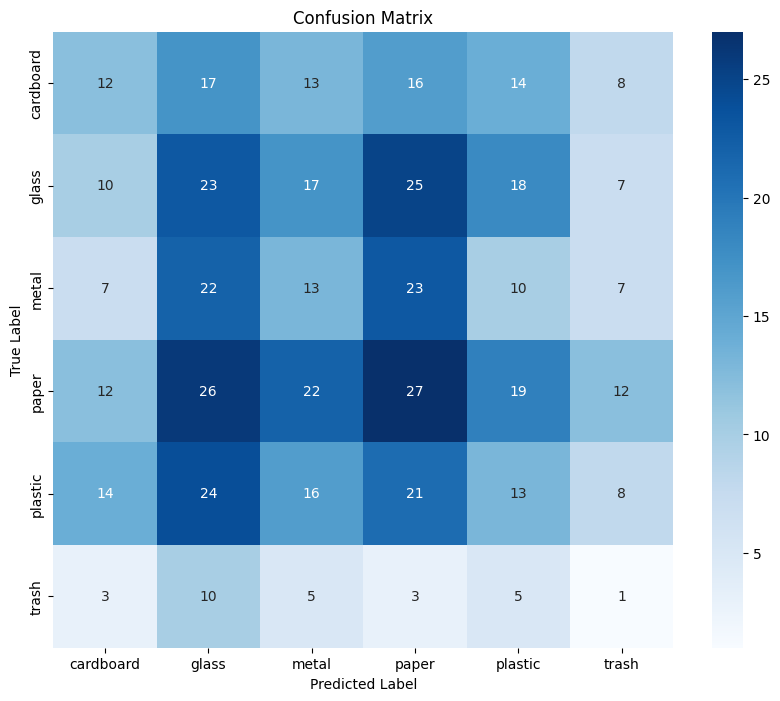

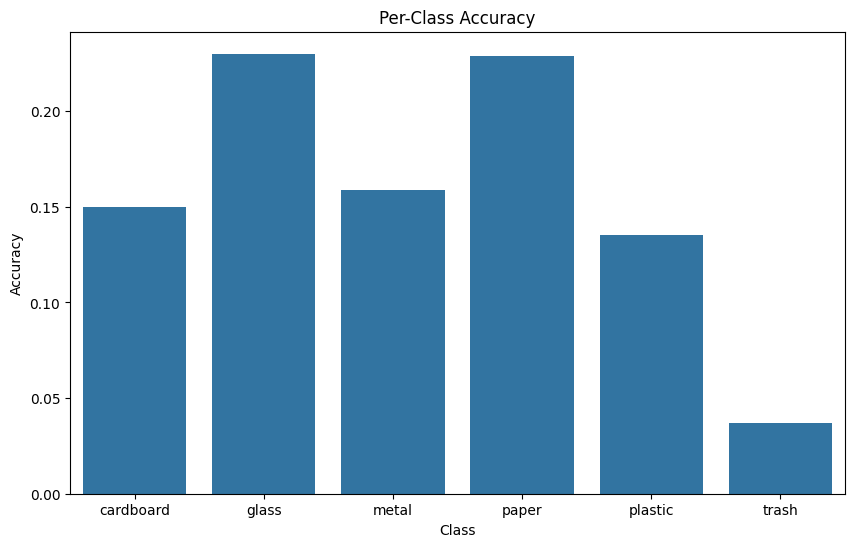

In [13]:
_, validation_generator = generate_data(is_aug=False)
plot_confusion_matrix(model_base, validation_generator)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/st ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/st ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/st ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step
Classification Report
              precision    recall  f1-score   support

   cardboard       0.17      0.15      0.16        80
       glass       0.19      0.17      0.18       100
       metal       0.16      0.27      0.20        82
       paper       0.24      0.19      0.21       118
     plastic       0.14      0.14      0.14        96
       trash       0.00      0.00      0.00        27

    accuracy                   

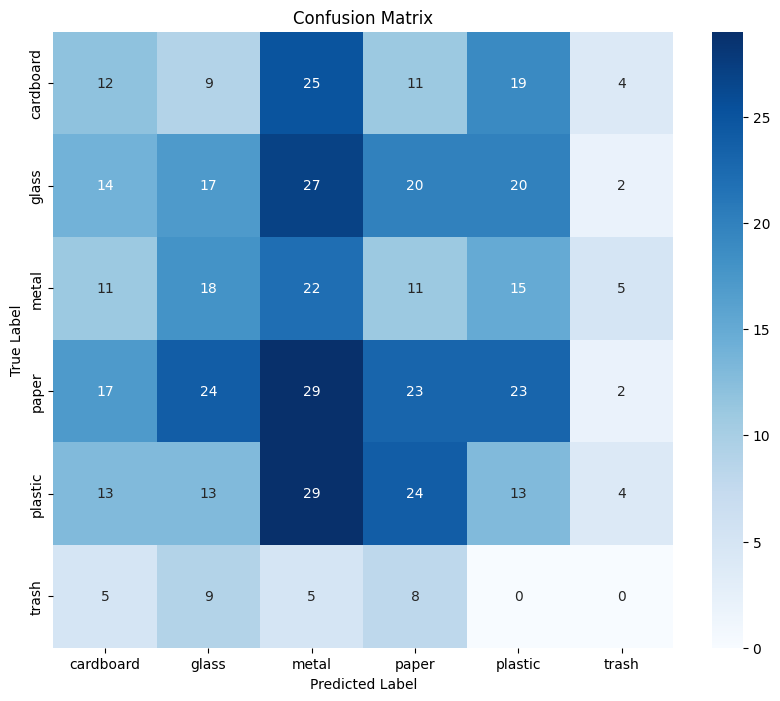

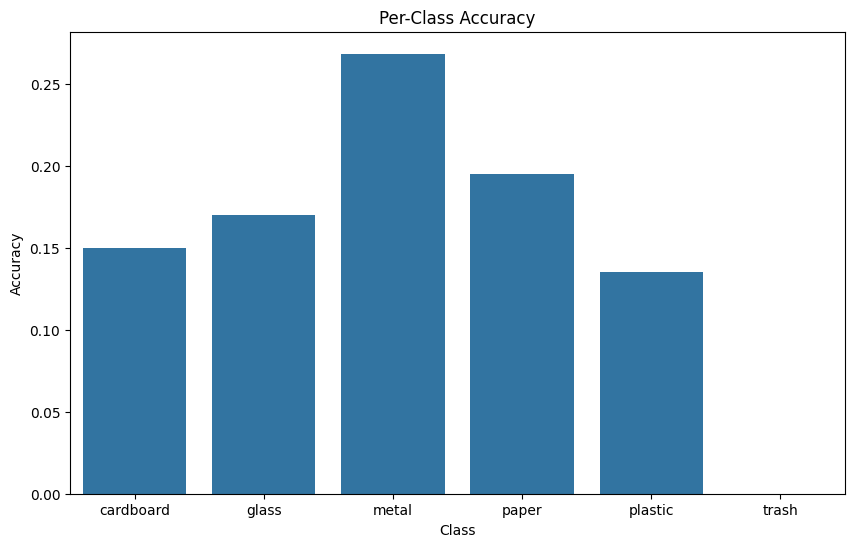

In [14]:
_, validation_generator_aug = generate_data(is_aug=True)
plot_confusion_matrix(model_aug, validation_generator_aug)